**SVM_Undersampling without Aggregation - Unseen Data Testing**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Random seed for reproducibility
np.random.seed(17)

In [2]:
# ===================== LOAD AND CLEAN DATA =====================
data_ksi = pd.read_csv("./Total_KSI.csv")

# Initial data overview
"""Displays an overview of the dataset."""
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

print("\n===================== DATA OVERVIEW =====================")
print("\nFirst 3 Records:\n", data_ksi.head(3))
print("\nShape of the DataFrame:", data_ksi.shape)
print("\nData Types:\n", data_ksi.dtypes)

print("\n===================== DATA DESCRIPTION =====================")
print("\nStatistical Summary:\n", data_ksi.describe())

print("\n===================== COLUMN INFORMATION =====================")
data_ksi.info()

print("\n===================== MISSING VALUES =====================")
missing_data = data_ksi.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(data_ksi)) * 100
print(pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percent Missing']))

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())

print("\n===================== UNIQUE VALUES =====================")
for column in data_ksi.columns:
    print(f"\nUnique values in {column} ({len(data_ksi[column].unique())}):", data_ksi[column].unique())


# Drop unnecessary columns

columns_to_drop = [ 'OBJECTID', 'INDEX',  # index_id 
    'FATAL_NO', # sequence No. - high missing values
    'OFFSET', #high missing values
    'x', 'y','CYCLISTYPE', 'PEDTYPE', 'PEDACT', # high correlation
    'EMERG_VEH',       # 0 permutation importance 
    'CYCCOND',         # 0 permutation importance 
    "NEIGHBOURHOOD_158","NEIGHBOURHOOD_140","STREET1","STREET2","INJURY"
]




===================== DATA OVERVIEW =====================

First 3 Records:
    OBJECTID    INDEX    ACCNUM                  DATE  TIME       STREET1  \
0         1  3389067  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
1         2  3389068  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
2         3  3389069  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   

       STREET2 OFFSET      ROAD_CLASS               DISTRICT   LATITUDE  \
0  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
1  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
2  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   

   LONGITUDE                ACCLOC    TRAFFCTL VISIBILITY LIGHT RDSFCOND  \
0 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
1 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
2 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   

           

In [3]:
# Drop unnecessary columns
data_ksi.drop(columns=columns_to_drop, inplace=True)

# Handle missing target values and specific rows
data_ksi['ACCLASS'] = data_ksi['ACCLASS'].fillna('Fatal')
data_ksi.drop(data_ksi[data_ksi['ACCLASS'] == 'Property Damage O'].index, inplace=True)
data_ksi.drop_duplicates(inplace=True)

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())


Class Distribution:
 ACCLASS
Non-Fatal Injury    15568
Fatal                2537
Name: count, dtype: int64


In [4]:
data_ksi.drop(columns=['ACCNUM'], inplace=True)

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())


Class Distribution:
 ACCLASS
Non-Fatal Injury    15568
Fatal                2537
Name: count, dtype: int64


In [5]:
# Map month numbers to seasons using the MONTH column
def month_to_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

In [6]:
def data_cleaning(data_ksi):

    data_ksi = data_ksi.copy()
    
    # Format date and time
    data_ksi["DATE"] = pd.to_datetime(data_ksi["DATE"]).dt.to_period("D").astype(str)
    
    # Extract date components from the 'DATE' column
    data_ksi['MONTH'] = pd.to_datetime(data_ksi['DATE']).dt.month
    
    # Extract season
    data_ksi['SEASON'] = data_ksi['MONTH'].apply(month_to_season).astype(float)
    
    # Replace specific values
    data_ksi['ROAD_CLASS'] = data_ksi['ROAD_CLASS'].str.replace(r'MAJOR ARTERIAL ', 'MAJOR ARTERIAL', regex=False)
    
    # Fill missing values
    unknown_columns = ['PEDCOND', 'DRIVCOND', 'MANOEUVER', 'CYCACT',
                        'VEHTYPE', 'INVTYPE', 'IMPACTYPE', 'DISTRICT', 'INITDIR']
    other_columns = ['ROAD_CLASS', 'ACCLOC', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'DRIVACT']
    boolean_columns = ['PEDESTRIAN', 'CYCLIST', 'MOTORCYCLE',
                       'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'TRSN_CITY_VEH', 'DISABILITY','AUTOMOBILE','TRUCK']
    
    data_ksi[boolean_columns] = data_ksi[boolean_columns].fillna("No")
    
    data_ksi['INVAGE'] = data_ksi['INVAGE'].fillna("unknown")
    
    # Handle age column
    data_ksi['INVAGE'] = data_ksi['INVAGE'].replace('unknown', np.nan)
    data_ksi['INVAGE'] = data_ksi['INVAGE'].str.replace('OVER 95', '95 to 100')
    data_ksi[['min_age', 'max_age']] = data_ksi['INVAGE'].str.split(' to ', expand=True)
    data_ksi['min_age'] = pd.to_numeric(data_ksi['min_age'], errors='coerce')
    data_ksi['max_age'] = pd.to_numeric(data_ksi['max_age'], errors='coerce')
    data_ksi['AVG_AGE'] = data_ksi[['min_age', 'max_age']].mean(axis=1).astype(float)
    
    data_ksi.drop(columns=['INVAGE','min_age', 'max_age'], inplace=True)
    data_ksi[other_columns] = data_ksi[other_columns].fillna("Other")
    data_ksi[unknown_columns] = data_ksi[unknown_columns].fillna("Unknown")
    
    # Convert boolean columns to numeric
    pd.set_option('future.no_silent_downcasting', True)
    data_ksi[boolean_columns] = data_ksi[boolean_columns].replace({'Yes': 1, 'No': 0}).astype(float)
    
    data_ksi["TRAFFCTL"] = data_ksi["TRAFFCTL"].fillna("No_Control")

    data_ksi["DIVISION"] = data_ksi["DIVISION"].replace('NSA', '00').str[1:].astype(float)

    # Replace 'NSA' with '00' and convert HOOD columns to float
    for col in ['HOOD_158', 'HOOD_140']:
        data_ksi[col] = data_ksi[col].replace('NSA', '00').astype(float)

    # Convert LATITUDE and LONGITUDE to float
    data_ksi[['LATITUDE', 'LONGITUDE']] = data_ksi[['LATITUDE', 'LONGITUDE']].astype(float)

    data_ksi['HOUR'] = data_ksi['TIME'].apply(lambda x: f"{int(x) // 100:02d}" if x >= 100 else '00')  # Extract hours for 3 or 4 digits
    data_ksi['MINUTE'] = data_ksi['TIME'].apply(lambda x: f"{int(x) % 100:02d}" if x >= 100 else f"{int(x):02d}")  # Extract minutes
    
    data_ksi['HOUR'] = data_ksi['HOUR'].astype(int)
    data_ksi['MINUTE'] = data_ksi['MINUTE'].astype(int)
    data_ksi.drop(columns=['TIME','DATE'], inplace=True)

    return data_ksi


In [7]:
from imblearn.under_sampling import RandomUnderSampler
# Handle class imbalance
rus = RandomUnderSampler(random_state=17)
X_res, y_res = rus.fit_resample(data_ksi.drop(columns=['ACCLASS']), data_ksi['ACCLASS'])
data_ksi = pd.concat([X_res, y_res], axis=1).sample(frac=1, random_state=17).reset_index(drop=True)
    
print("\n===================== DATA CLEANING DONE =====================")
print("\nShape of the DataFrame after cleaning:", data_ksi.shape)
print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())
    
print("\n===================== COLUMN INFORMATION =====================")
data_ksi.info()


===================== DATA CLEANING DONE =====================

Shape of the DataFrame after cleaning: (5074, 37)
Class Distribution:
 ACCLASS
Non-Fatal Injury    2537
Fatal               2537
Name: count, dtype: int64

===================== COLUMN INFORMATION =====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074 entries, 0 to 5073
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DATE           5074 non-null   object 
 1   TIME           5074 non-null   int64  
 2   ROAD_CLASS     4946 non-null   object 
 3   DISTRICT       5029 non-null   object 
 4   LATITUDE       5074 non-null   float64
 5   LONGITUDE      5074 non-null   float64
 6   ACCLOC         3613 non-null   object 
 7   TRAFFCTL       5058 non-null   object 
 8   VISIBILITY     5050 non-null   object 
 9   LIGHT          5070 non-null   object 
 10  RDSFCOND       5045 non-null   object 
 11  IMPACTYPE      5069 non-null   o

In [8]:
data_ksi = data_cleaning(data_ksi)

In [9]:
print("\n===================== UNIQUE VALUES =====================")
for column in data_ksi.columns:
    print(f"\nUnique values in {column}:", data_ksi[column].unique())


===================== UNIQUE VALUES =====================

Unique values in ROAD_CLASS: ['Major Arterial' 'Minor Arterial' 'Major Arterial ' 'Collector' 'Local'
 'Other' 'Expressway Ramp' 'Expressway' 'Pending' 'Laneway'
 'Major Shoreline']

Unique values in DISTRICT: ['North York' 'Scarborough' 'Toronto and East York' 'Etobicoke York'
 'Unknown']

Unique values in LATITUDE: [43.761031 43.720645 43.760802 ... 43.640547 43.743109 43.743121]

Unique values in LONGITUDE: [-79.465198 -79.24259  -79.215762 ... -79.423999 -79.218875 -79.582706]

Unique values in ACCLOC: ['At Intersection' 'Other' 'Non Intersection' 'Intersection Related'
 'At/Near Private Drive' 'Private Driveway' 'Overpass or Bridge'
 'Underpass or Tunnel' 'Laneway' 'Trail']

Unique values in TRAFFCTL: ['Traffic Signal' 'No Control' 'Stop Sign' 'Traffic Controller'
 'Pedestrian Crossover' 'No_Control' 'Police Control' 'Yield Sign'
 'Traffic Gate' 'Streetcar (Stop for)' 'School Guard']

Unique values in VISIBILITY: ['Clear'

In [10]:
# ===================== DEFINE PARAMETER GRIDS =====================
# SVM hyperparameter grid 
param_grid_svm = [
        {'svm__kernel': ['linear'], 'svm__C': [1]},  # linear kernel    
        {'svm__kernel': ['rbf'], 'svm__C': [0.01, 1.0], 'svm__gamma': [0.03, 0.3, 3.0]},  # rbf kernel 
        {'svm__kernel': ['poly'], 'svm__C': [0.1, 1, 10], 'svm__gamma': [0.1, 0.3, 1.0], 'svm__degree': [3]}  # poly kernel 
    ]

features = data_ksi.drop(columns=["ACCLASS"])
target = data_ksi["ACCLASS"]

unseen_features = features[-10:]
unseen_labels = target[-10:]

features = features[:-10]
target = target[:-10]

cleaned_df = data_ksi.drop(data_ksi.index[-10:])

# Encode the target variable
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Encode unseen labels
unseen_labels = label_encoder.transform(unseen_labels)

# Preprocess the data
num_features = features.select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = features.select_dtypes(include=['object']).columns.tolist()

print("\n===================== FEATURES INFO =====================")
print(f"\nNumerical Features:{len(num_features)}", num_features)
print(f"\nCategorical Features:{len(num_features)}", cat_features)


===================== FEATURES INFO =====================

Numerical Features:22 ['LATITUDE', 'LONGITUDE', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'HOOD_158', 'HOOD_140', 'DIVISION', 'MONTH', 'SEASON', 'AVG_AGE', 'HOUR', 'MINUTE']

Categorical Features:22 ['ROAD_CLASS', 'DISTRICT', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDCOND', 'CYCACT']


In [11]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split the data into train & test
X_train, X_test, y_train, y_test = train_test_split(
        features, target, stratify=target, test_size=0.2, random_state=17)

# Preprocess the data
num_features = features.select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = features.select_dtypes(include=['object']).columns.tolist()

print("\n===================== FEATURES INFO =====================")
print("\nNumerical Features:", num_features)
print("\nCategorical Features:", cat_features)

num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='mode')),
        ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

preprocessor = ColumnTransformer([
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

pipe_svm_ksi = Pipeline([
            ('preprocessor', preprocessor),
            ('svm', SVC(random_state=17))
        ])



===================== FEATURES INFO =====================

Numerical Features: ['LATITUDE', 'LONGITUDE', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'HOOD_158', 'HOOD_140', 'DIVISION', 'MONTH', 'SEASON', 'AVG_AGE', 'HOUR', 'MINUTE']

Categorical Features: ['ROAD_CLASS', 'DISTRICT', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDCOND', 'CYCACT']


In [12]:
grid_search = GridSearchCV(estimator=pipe_svm_ksi, param_grid=param_grid_svm, scoring='accuracy', refit=True, verbose=3)

In [13]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ......svm__C=1, svm__kernel=linear;, score=0.652 total time=   4.6s
[CV 2/5] END ......svm__C=1, svm__kernel=linear;, score=0.683 total time=   4.9s
[CV 3/5] END ......svm__C=1, svm__kernel=linear;, score=0.667 total time=   4.9s
[CV 4/5] END ......svm__C=1, svm__kernel=linear;, score=0.675 total time=   4.7s
[CV 5/5] END ......svm__C=1, svm__kernel=linear;, score=0.686 total time=   4.6s
[CV 1/5] END svm__C=0.01, svm__gamma=0.03, svm__kernel=rbf;, score=0.618 total time=   4.8s
[CV 2/5] END svm__C=0.01, svm__gamma=0.03, svm__kernel=rbf;, score=0.500 total time=   5.0s
[CV 3/5] END svm__C=0.01, svm__gamma=0.03, svm__kernel=rbf;, score=0.500 total time=   4.8s
[CV 4/5] END svm__C=0.01, svm__gamma=0.03, svm__kernel=rbf;, score=0.500 total time=   4.9s
[CV 5/5] END svm__C=0.01, svm__gamma=0.03, svm__kernel=rbf;, score=0.500 total time=   4.9s
[CV 1/5] END svm__C=0.01, svm__gamma=0.3, svm__kernel=rbf;, score=0.514 to

In [14]:
from model_performance import ModelPerformance
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Predict using the best model
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

modelPerformance = ModelPerformance(best_model, X_test, y_test)

# Print classification report for detailed performance metrics
print("\n===================== CLASSIFICATION REPORT =====================")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

#Precison, Recall, F1-Score
print("\n===================== PRECISION, RECALL, F1-SCORE =====================")
print("\nPrecision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred, average='weighted'))


===================== CLASSIFICATION REPORT =====================

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.75       506
           1       0.75      0.74      0.75       507

    accuracy                           0.75      1013
   macro avg       0.75      0.75      0.75      1013
weighted avg       0.75      0.75      0.75      1013


===================== PRECISION, RECALL, F1-SCORE =====================

Precision: 0.7493257321007514
Recall: 0.7492596248766041
F1-Score: 0.7492459408425663
ROC-AUC Score: 0.7492671765247017


In [15]:
print("\n===================== BEST MODEL METRICS =====================")
print("\nBest Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
print("Best Training Accuracy:", grid_search.best_score_)

accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

import joblib

# Save the model
joblib.dump(best_model, "./best_model.pkl")
print("\nModel saved successfully.")


===================== BEST MODEL METRICS =====================

Best Parameters: {'svm__C': 0.1, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'PEDESTRIAN', 'CYCLIST',
                                                   'AUTOMOBILE', 'MOTORCYCLE',
                                                   'TRUCK', 'TRSN_CITY_VEH',
                                                   'PASSENGER', 'SPEEDING',
       

In [16]:
 # Handling unseen data
best_model.fit(unseen_features, unseen_labels)
unseen_predictions = best_model.predict(unseen_features)
unseen_accuracy = best_model.score(unseen_features, unseen_labels)

print("\n===================== UNSEEN DATA METRICS =====================")
print("\nUnseen Predictions:", unseen_predictions)
for i in range(len(unseen_features)):
    print(f"Predicted: {unseen_predictions[i]} Actual: {unseen_labels[i]}")

print(f"Unseen Data Accuracy: {unseen_accuracy:.4f}")


===================== UNSEEN DATA METRICS =====================

Unseen Predictions: [1 1 1 0 0 1 0 0 0 1]
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Unseen Data Accuracy: 1.0000


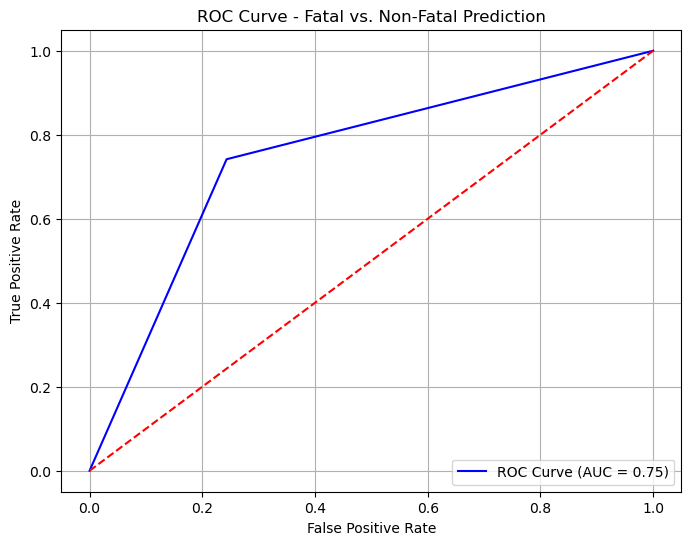

In [17]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred):.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve - Fatal vs. Non-Fatal Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

          Feature  Importance Mean  Importance Std
0      PEDESTRIAN        -0.023297        0.004738
1       LONGITUDE        -0.010661        0.002013
2           LIGHT        -0.009674        0.002285
3        TRAFFCTL        -0.008687        0.002955
4       IMPACTYPE        -0.008095        0.004113
5          MINUTE        -0.006318        0.002126
6         INITDIR        -0.006318        0.002968
7           MONTH        -0.004146        0.011654
8        DRIVCOND        -0.003356        0.003565
9         CYCLIST        -0.002172        0.002369
10       LATITUDE        -0.001777        0.007371
11       HOOD_158        -0.001382        0.006684
12     MOTORCYCLE         0.000000        0.000000
13       SPEEDING         0.000000        0.000000
14       REDLIGHT         0.000000        0.000000
15        ALCOHOL         0.000000        0.000000
16     DISABILITY         0.000000        0.000000
17  TRSN_CITY_VEH         0.000000        0.000000
18      PASSENGER         0.000

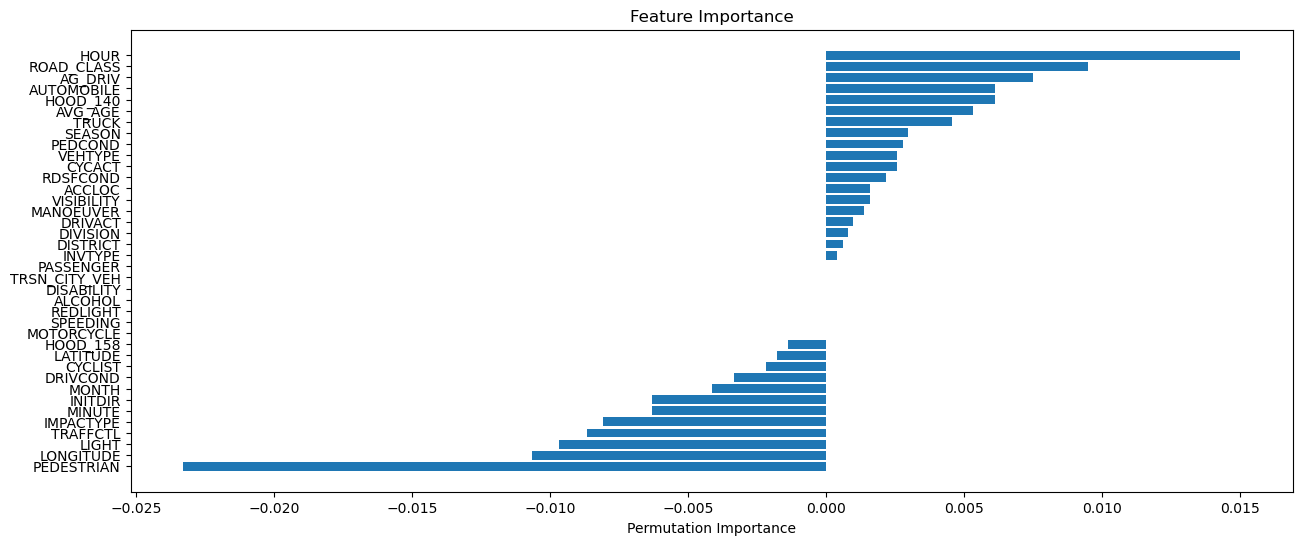

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

feature_names = features.columns if hasattr(features, 'columns') else [f"Feature {i}" for i in range(features.shape[1])]

perm_importance = permutation_importance(best_model, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()

importance_df = pd.DataFrame({
    "Feature": np.array(feature_names)[sorted_idx],
    "Importance Mean": perm_importance.importances_mean[sorted_idx],
    "Importance Std": perm_importance.importances_std[sorted_idx]
})

print(importance_df)

# Plot permutation importance
plt.figure(figsize=(15, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

          Feature  Importance Mean  Importance Std
0      PEDESTRIAN        -0.020044        0.002548
1           LIGHT        -0.006369        0.001595
2       IMPACTYPE        -0.005727        0.001493
3        HOOD_158        -0.003999        0.003524
4      ROAD_CLASS        -0.003357        0.001954
5        TRAFFCTL        -0.002715        0.002118
6        HOOD_140        -0.002567        0.002520
7         INVTYPE        -0.002320        0.002104
8         DRIVACT        -0.001530        0.000955
9         CYCLIST        -0.000987        0.001012
10     DISABILITY         0.000000        0.000000
11        ALCOHOL         0.000000        0.000000
12       REDLIGHT         0.000000        0.000000
13        AG_DRIV         0.000000        0.002434
14       SPEEDING         0.000000        0.000000
15      PASSENGER         0.000000        0.000000
16  TRSN_CITY_VEH         0.000000        0.000000
17     MOTORCYCLE         0.000000        0.000000
18         MINUTE         0.000

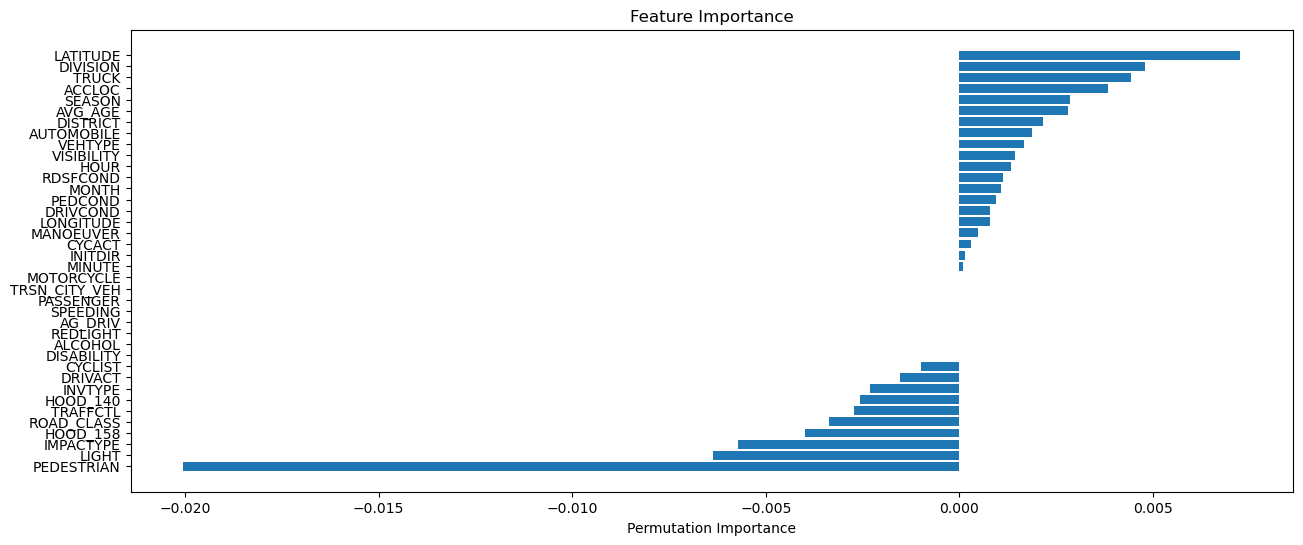

In [19]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

feature_names = features.columns if hasattr(features, 'columns') else [f"Feature {i}" for i in range(features.shape[1])]

perm_importance = permutation_importance(best_model, X_train, y_train)

sorted_idx = perm_importance.importances_mean.argsort()

importance_df = pd.DataFrame({
    "Feature": np.array(feature_names)[sorted_idx],
    "Importance Mean": perm_importance.importances_mean[sorted_idx],
    "Importance Std": perm_importance.importances_std[sorted_idx]
})

print(importance_df)

# Plot permutation importance
plt.figure(figsize=(15, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

**Unseen Extracted Rows**

In [21]:
from sklearn.metrics import accuracy_score

unseen_data = pd.read_csv("./excluded_rows.csv")
unseen_df = data_cleaning(unseen_data)

unseen_features = unseen_df.drop(columns=["ACCLASS"])
unseen_target = unseen_df["ACCLASS"]

transformed_unseen_features = preprocessor.fit_transform(unseen_features)
transformed_unseen_target = label_encoder.transform(unseen_target)

predictions = best_model.predict(unseen_features)

accuracy = accuracy_score(transformed_unseen_target, predictions)

print(f"Accuracy on Unseen Data: {accuracy * 100:.2f}%")


Accuracy on Unseen Data: 43.70%
